In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from scipy.stats import pearsonr
sns.set_style('dark')

In [3]:
emotions = ['joy', 'surprise', 'fear', 'anger', 'sadness', 'disgust']
save_dir = '/home/smarda/Writing/BodyTweetsPaper/figures/'
tables_dir = '/home/smarda/Writing/BodyTweetsPaper/tables/'

In [4]:
'''
usecols = [
    'Geographic Area Name',
    'Estimate!!SEX AND AGE!!Total population!!Median age (years)',
    'Margin of Error!!SEX AND AGE!!Total population!!Median age (years)',
    'Estimate!!MARITAL STATUS!!Population 15 years and over!!Now married, except separated',
    'Margin of Error!!MARITAL STATUS!!Population 15 years and over!!Now married, except separated',
    'Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher',
    'Margin of Error!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher',
    'Estimate!!POVERTY RATES FOR FAMILIES AND PEOPLE FOR WHOM POVERTY STATUS IS DETERMINED!!All families',
    'Margin of Error!!POVERTY RATES FOR FAMILIES AND PEOPLE FOR WHOM POVERTY STATUS IS DETERMINED!!All families',
    'Estimate!!PLACE OF BIRTH, CITIZENSHIP STATUS AND YEAR OF ENTRY!!Foreign born',
    'Margin of Error!!PLACE OF BIRTH, CITIZENSHIP STATUS AND YEAR OF ENTRY!!Foreign born',
    'Estimate!!TOTAL NUMBER OF RACES REPORTED!!Total population',  
]
'''
usecols = ['Geographic Area Name',
    'Estimate!!SEX AND AGE!!Total population!!Median age (years)',
    'Estimate!!MARITAL STATUS!!Population 15 years and over!!Now married, except separated',
    'Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher',
    'Estimate!!POVERTY RATES FOR FAMILIES AND PEOPLE FOR WHOM POVERTY STATUS IS DETERMINED!!All families',
    'Estimate!!PLACE OF BIRTH, CITIZENSHIP STATUS AND YEAR OF ENTRY!!Foreign born',
    'Estimate!!TOTAL NUMBER OF RACES REPORTED!!Total population',  
]
raw = pd.read_csv('../public_data/usacs_demographic_data.csv', skiprows=1, usecols=usecols)
renamed = ['state','median_age_years', 'married_proportion', 'educated_proportion', 'in_poverty_proportion', 'num_foreign_born','total_pop']
df = raw.rename(columns={i:j for i,j in zip(usecols, renamed)})
for col in ['married_proportion', 'educated_proportion', 'in_poverty_proportion']:
    df[col] = df[col] / 100
df['foreign_born_rate'] = df['num_foreign_born'] / df['total_pop']
df = df.drop(columns=['num_foreign_born','total_pop'])
df.head()

,state,median_age_years,married_proportion,educated_proportion,in_poverty_proportion,foreign_born_rate
0,Alabama,39.4,0.476,0.263,0.112,0.035681
1,Alaska,35.0,0.494,0.302,0.066,0.079801
2,Arizona,38.3,0.470,0.302,0.095,0.134131
3,Arkansas,38.8,0.486,0.233,0.117,0.051125
4,California,37.0,0.465,0.350,0.082,0.267366


In [5]:
df['state'].unique().shape

(51,)

In [6]:
tweets_df = pd.read_parquet('/dlabdata1/smarda/private_data/master/tweets_with_scores.parquet.gzip', columns=['final_state', 'vader_score'] + emotions)
sum(tweets_df['final_state'].str.contains('Washington'))

9566

In [7]:
tweets_df.columns

Index(['final_state', 'vader_score', 'joy', 'surprise', 'fear', 'anger',
       'sadness', 'disgust'],
      dtype='object')

In [12]:
tweets_df = pd.read_parquet('/dlabdata1/smarda/private_data/master/tweets_with_scores.parquet.gzip', columns=['final_state', 'vader_score'] + emotions)
tweets_df = tweets_df[tweets_df['final_state'] != 'Puerto Rico']
tweets_df.shape

(421305, 8)

In [13]:
grouped = tweets_df.groupby('final_state').mean().reset_index()
grouped.head()

,final_state,vader_score,joy,surprise,fear,anger,sadness,disgust
0,Alabama,0.069340,0.441698,0.086816,0.093700,0.043599,0.180635,0.153552
1,Alaska,0.067676,0.448000,0.086794,0.092133,0.043033,0.176183,0.153858
2,Arizona,0.072230,0.449087,0.087597,0.092599,0.042235,0.177447,0.151035
3,Arkansas,0.079480,0.442136,0.090176,0.094455,0.040125,0.177000,0.156108
4,California,0.097047,0.445717,0.086627,0.093368,0.042365,0.180006,0.151917


In [14]:
melted = pd.melt(tweets_df, id_vars='final_state', value_vars=emotions+['vader_score'], var_name='emotion', value_name='score')
melted.head()

,final_state,emotion,score
0,Nebraska,joy,0.050008
1,Florida,joy,0.720429
2,Texas,joy,0.967715
3,Idaho,joy,0.084153
4,Idaho,joy,0.914460


In [15]:
melted['emotion'].unique().shape

(7,)

In [16]:
grouped_melted = pd.melt(grouped, id_vars='final_state', value_vars=emotions, var_name='emotion', value_name='score')
grouped_melted.head()

,final_state,emotion,score
0,Alabama,joy,0.441698
1,Alaska,joy,0.448000
2,Arizona,joy,0.449087
3,Arkansas,joy,0.442136
4,California,joy,0.445717


<AxesSubplot:xlabel='final_state', ylabel='joy'>

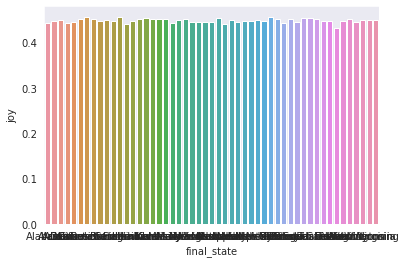

In [17]:
sns.barplot(data=grouped, x='final_state', y='joy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/figures/state_distributions.pdf'

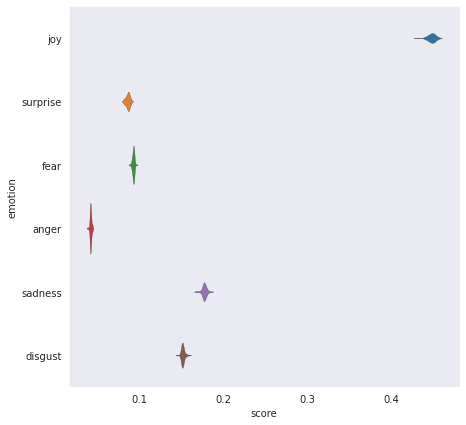

In [18]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax = sns.violinplot(data=grouped_melted, y='emotion', x='score', inner=None, linewidth=0.3)
plt.savefig(save_dir + 'state_distributions.pdf', dpi=300)

In [19]:
grouped.describe()

,vader_score,joy,surprise,fear,anger,sadness,disgust
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.082354,0.448274,0.086544,0.093177,0.042289,0.177632,0.152084
std,0.022590,0.004639,0.002324,0.001316,0.001036,0.003076,0.002204
min,0.039381,0.431301,0.081463,0.088837,0.038700,0.168495,0.145510
25%,0.069448,0.445707,0.085200,0.092455,0.041789,0.176708,0.150803
50%,0.079480,0.448982,0.086946,0.093329,0.042229,0.177447,0.151917
75%,0.089297,0.451196,0.087997,0.093990,0.042773,0.179052,0.152873
max,0.190430,0.456405,0.090868,0.097123,0.044688,0.185751,0.159901


In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
grouped.describe().drop('count').to_latex(tables_dir + 'state_dists_describe.tex')
grouped.describe().drop('count').to_latex()

FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/tables/state_dists_describe.tex'

In [21]:
grouped = g

NameError: name 'g' is not defined

FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/figures/bystate_joy_dist.pdf'

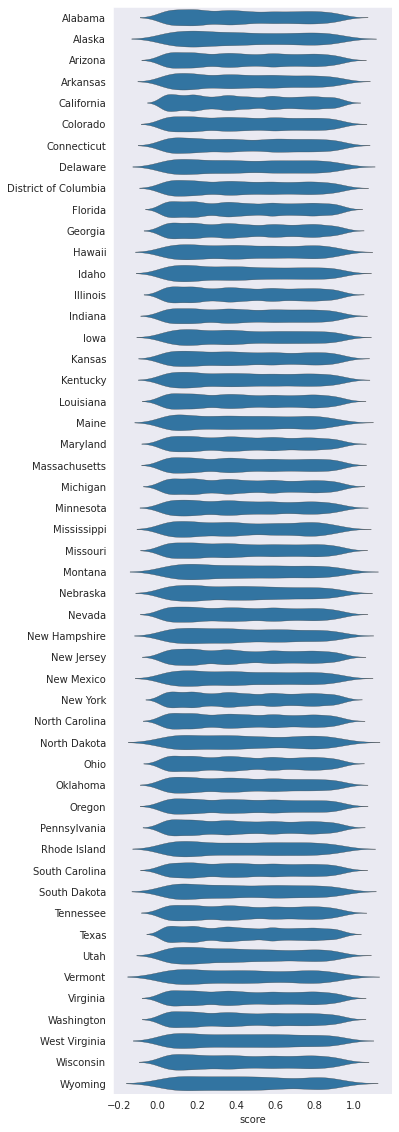

In [22]:
fig, ax = plt.subplots(1,1, figsize=(5,20))
ax = sns.violinplot(data=melted[melted['emotion']=='joy'].sort_values('final_state'), y='final_state', x='score', ax=ax, inner=None, linewidth=0.3,
              color='tab:blue')
ax.set_ylabel('')
plt.savefig(save_dir + 'bystate_joy_dist.pdf', dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/figures/bystate_sadness_dist.pdf'

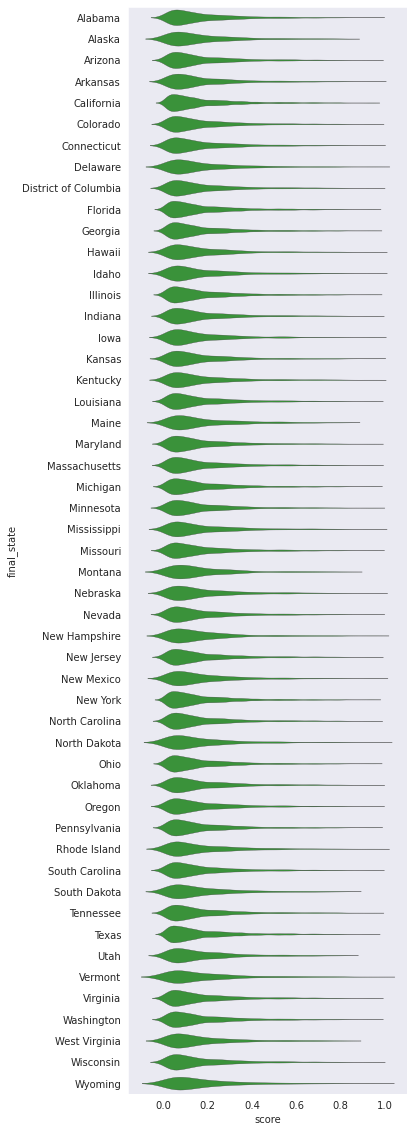

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5,20))
ax = sns.violinplot(data=melted[melted['emotion']=='sadness'].sort_values('final_state'), y='final_state', x='score', ax=ax, inner=None, linewidth=0.3,
              color='tab:green')
plt.savefig(save_dir + 'bystate_sadness_dist.pdf', dpi=300)

# Vader

<AxesSubplot:xlabel='score', ylabel='Count'>

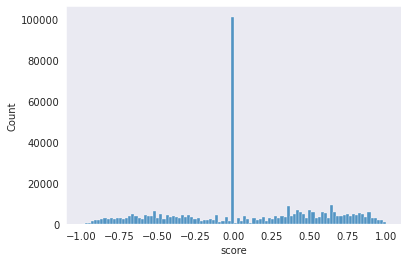

In [24]:
vader = melted[melted['emotion'] == 'vader_score']
sns.histplot(vader['score'])

# Demo Analysis

In [25]:
import statsmodels.api as sm

spector_data = sm.datasets.spector.load(as_pandas=True)
spector_data.head()

AttributeError: 'Dataset' object has no attribute 'head'

In [26]:
grouped = grouped[grouped['final_state'] != 'Puerto Rico']

In [27]:
demo_df = pd.concat([grouped[['final_state','vader_score','joy']], df[df.columns[1:]]], axis=1)

In [28]:
demo_df = pd.merge(grouped[['final_state','vader_score','joy']], df, left_on='final_state', right_on='state')

In [29]:
demo_df['final_state'][~demo_df['final_state'].isin(df['state'])]

Series([], Name: final_state, dtype: object)

In [30]:
df['state'].unique().shape

(51,)

In [31]:
grouped['final_state'].unique().shape

(51,)

In [32]:
demo_df['vader_score'].isnull().any()

False

In [33]:
grouped.head()

,final_state,vader_score,joy,surprise,fear,anger,sadness,disgust
0,Alabama,0.069,0.442,0.087,0.094,0.044,0.181,0.154
1,Alaska,0.068,0.448,0.087,0.092,0.043,0.176,0.154
2,Arizona,0.072,0.449,0.088,0.093,0.042,0.177,0.151
3,Arkansas,0.079,0.442,0.090,0.094,0.040,0.177,0.156
4,California,0.097,0.446,0.087,0.093,0.042,0.180,0.152


In [34]:
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('median_age_years ~ vader_score', data=demo_df, return_type='dataframe')
mod = sm.OLS(y,X).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:       median_age_years   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.995
Date:                Wed, 08 Sep 2021   Prob (F-statistic):             0.0898
Time:                        19:08:01   Log-Likelihood:                -114.09
No. Observations:                  51   AIC:                             232.2
Df Residuals:                      49   BIC:                             236.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      40.8569      1.235     33.079      

In [35]:
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('median_age_years ~ joy', data=demo_df, return_type='dataframe')
mod = sm.OLS(y,X).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:       median_age_years   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4.244
Date:                Wed, 08 Sep 2021   Prob (F-statistic):             0.0447
Time:                        19:08:01   Log-Likelihood:                -113.48
No. Observations:                  51   AIC:                             231.0
Df Residuals:                      49   BIC:                             234.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.5302     31.224     -0.818      0.4

In [36]:
grouped['final_state'].shape

(51,)

In [37]:
demo_df['final_state'].shape

(51,)

In [38]:
demo_df.head()

,final_state,vader_score,joy,state,median_age_years,married_proportion,educated_proportion,in_poverty_proportion,foreign_born_rate
0,Alabama,0.069,0.442,Alabama,39.400,0.476,0.263,0.112,0.036
1,Alaska,0.068,0.448,Alaska,35.000,0.494,0.302,0.066,0.080
2,Arizona,0.072,0.449,Arizona,38.300,0.470,0.302,0.095,0.134
3,Arkansas,0.079,0.442,Arkansas,38.800,0.486,0.233,0.117,0.051
4,California,0.097,0.446,California,37.000,0.465,0.350,0.082,0.267


In [39]:
demo_df[demo_df.isnull().any(axis=1)]

,final_state,vader_score,joy,state,median_age_years,married_proportion,educated_proportion,in_poverty_proportion,foreign_born_rate


Index(['median_age_years', 'married_proportion', 'educated_proportion',
       'in_poverty_proportion', 'foreign_born_rate'],
      dtype='object')


FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/figures/correlations.pdf'

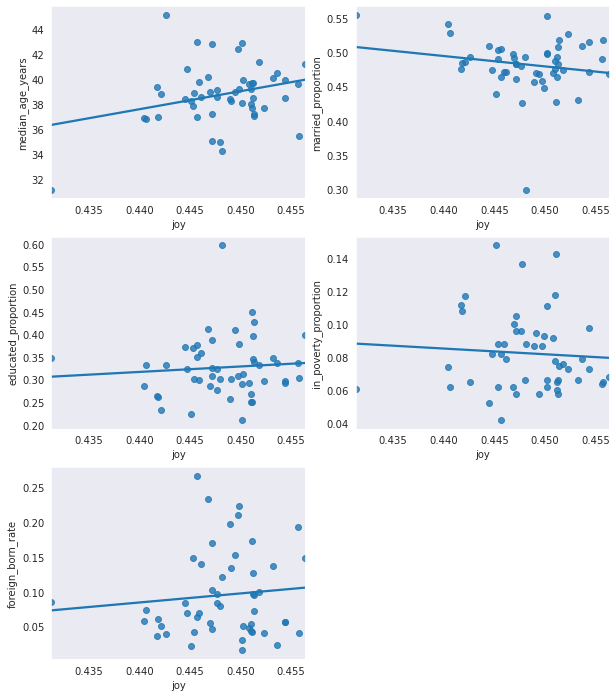

In [42]:
demo_vars = demo_df.columns[4:]
print(demo_vars)

'''
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
'''
fig, axes = plt.subplots(3,2,figsize=(10,12))
axes[-1,-1].axis('off')
axes = axes.flatten()
corr_df = pd.DataFrame(columns=['Pearson R', 'p-value'])
for i in range(len(demo_vars)):
    ax = axes[i]
    r, pvalue = pearsonr(demo_df['joy'], demo_df[demo_vars[i]])
    demo_df[demo_vars[i]] = demo_df[demo_vars[i]].astype(float)
    demo_df['joy'] = demo_df['joy'].astype(float)
    sns.regplot(data=demo_df, x='joy', y=demo_vars[i], ax=ax, ci=None, color='tab:blue')
    corr_df = corr_df.append({'Pearson R': r, 'p-value': pvalue}, ignore_index=True)
plt.savefig(save_dir + 'correlations.pdf', dpi=300)
plt.show()

Index(['median_age_years', 'married_proportion', 'educated_proportion',
       'in_poverty_proportion', 'foreign_born_rate'],
      dtype='object')


FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/figures/correlations.pdf'

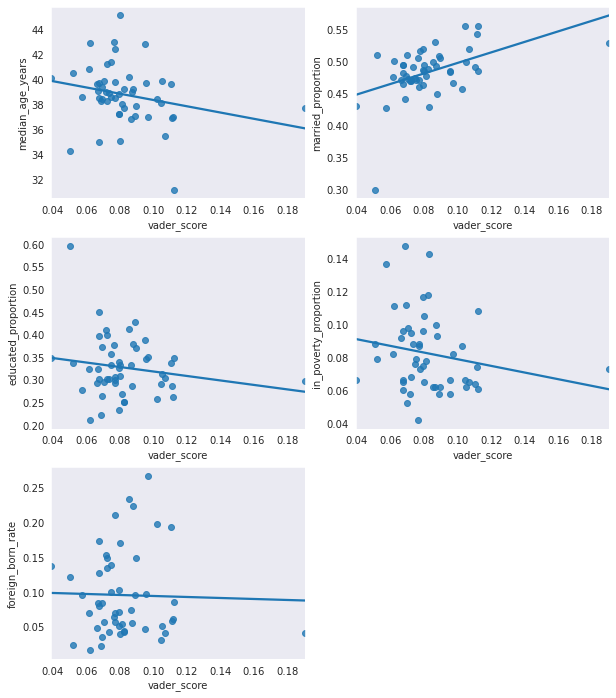

In [43]:
demo_vars = demo_df.columns[4:]
print(demo_vars)

'''
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
'''
fig, axes = plt.subplots(3,2,figsize=(10,12))
axes[-1,-1].axis('off')
axes = axes.flatten()
corr_df = pd.DataFrame(columns=['Pearson R', 'p-value'])
for i in range(len(demo_vars)):
    ax = axes[i]
    r, pvalue = pearsonr(demo_df['vader_score'], demo_df[demo_vars[i]])
    demo_df[demo_vars[i]] = demo_df[demo_vars[i]].astype(float)
    demo_df['vader_score'] = demo_df['vader_score'].astype(float)
    sns.regplot(data=demo_df, x='vader_score', y=demo_vars[i], ax=ax, ci=None, color='tab:blue')
    corr_df = corr_df.append({'Pearson R': r, 'p-value': pvalue}, ignore_index=True)
plt.savefig(save_dir + 'correlations.pdf', dpi=300)
plt.show()

In [44]:
corr_df.index = ['median_age_years','married_proportion','educated_proportion','in_poverty_proportion','foreign_born_rate']
corr_df.head()

,Pearson R,p-value
median_age_years,-0.240,0.090
married_proportion,0.478,0.000
educated_proportion,-0.171,0.229
in_poverty_proportion,-0.195,0.171
foreign_born_rate,-0.026,0.854


In [45]:
corr_df.to_latex(tables_dir + 'corr_coeffs.tex')

FileNotFoundError: [Errno 2] No such file or directory: '/home/smarda/Writing/BodyTweetsPaper/tables/corr_coeffs.tex'

In [ ]:
ax = sns.regplot(data=demo_df, x='joy', y='median_age_years',logistic=False, ci=None)

In [ ]:
sns.regplot(data=demo_df, x='median_age_years', y='joy',logistic=True, ci=None)

In [ ]:
sns.regplot(data=demo_df, x='married_proportion', y='joy', ci=None)

In [ ]:
sns.regplot(data=demo_df, x='educated_proportion', y='joy', ci=None)

In [ ]:
ax = sns.regplot(data=demo_df, x='in_poverty_proportion', y='joy', ci=None)
ax.set_ylim([0.4, 0.5])
ax.set_xlim([0,1])

In [ ]:
ax = sns.regplot(data=demo_df, x='foreign_born_rate', y='joy', ci=None)